## Car price prediction - Kaggle

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy.stats import shapiro, normaltest
from colorama import Style, Fore
import os
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor, SGDRegressor, BayesianRidge, PoissonRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

*Data column info\
model : 브랜드명\
year : 제조년도\
motor_type : 엔진 종류\
running : 주행거리\
wheel\
color : 차 색상\
type : 차 유형\
status : 차 상태\
motor_volume : 엔진 배기량(L)\
price : 가격(USD)

In [2]:
train = pd.read_csv('train_copy.csv')
test = pd.read_csv('test_copy.csv')

### 1. 데이터 확인

In [3]:
# Shape
print(f"{Style.BRIGHT}{Fore.YELLOW}train_shape : {train.shape}")
print(f"{Style.BRIGHT}{Fore.YELLOW}test_shape : {test.shape}")
print(Style.RESET_ALL)

# Missing value - column
# missing_values = train.isnull().sum()
# print(missing_values)

# Missing value 개수
total_missing = train.isnull().sum().sum()
print(f"{Style.BRIGHT}{Fore.CYAN}Total number of missing values in the dataset: {total_missing}")
# Duplicate 개수
print(f"\ntrain Duplicates : {train[train.duplicated()].shape[0]}")

train_shape : (1642, 10)
test_shape : (411, 10)

Total number of missing values in the dataset: 0

train Duplicates : 9


In [4]:
# train dataset info
desc = pd.DataFrame(index = list(train))
desc['type'] = train.dtypes
desc['count'] = train.count()
desc['uniq'] = train.nunique()
# 각 열에서 고유한 값이 전체 데이터에서 차지하는 비율
desc['%uniq'] = desc['uniq'] /len(train) * 100
desc['null'] = train.isnull().sum()
# count 값 제외, 기술통계 전치해서 표현, 기존 병합 
desc = pd.concat([desc,train.describe().T.drop('count',axis=1)],axis=1)

styled_desc = desc.sort_values(by=['type', 'null']).style.background_gradient(cmap='viridis')
styled_desc

,type,count,uniq,%uniq,null,mean,std,min,25%,50%,75%,max
year,int64,1642,32,1.948843,0,2014.805725,6.587573,1987.000000,2013.000000,2017.000000,2019.000000,2023.000000
price,int64,1642,294,17.904994,0,15982.633374,7176.084647,462.000000,12000.000000,15750.000000,18500.000000,87000.000000
motor_volume,float64,1642,20,1.218027,0,2.035018,0.253069,0.200000,2.000000,2.000000,2.000000,4.000000
model,object,1642,5,0.304507,0,nan,nan,nan,nan,nan,nan,nan
motor_type,object,1642,5,0.304507,0,nan,nan,nan,nan,nan,nan,nan
running,object,1642,643,39.159562,0,nan,nan,nan,nan,nan,nan,nan
wheel,object,1642,1,0.060901,0,nan,nan,nan,nan,nan,nan,nan
color,object,1642,17,1.035323,0,nan,nan,nan,nan,nan,nan,nan
type,object,1642,7,0.426309,0,nan,nan,nan,nan,nan,nan,nan
status,object,1642,5,0.304507,0,nan,nan,nan,nan,nan,nan,nan


In [5]:
# test dataset info
desc = pd.DataFrame(index = list(test))
desc['type'] = test.dtypes
desc['count'] = test.count()
desc['uniq'] = test.nunique()
# 각 열에서 고유한 값이 전체 데이터에서 차지하는 비율
desc['%uniq'] = desc['uniq'] /len(test) * 100
desc['null'] = test.isnull().sum()
# count 값 제외, 기술통계 전치해서 표현, 기존 병합 
desc = pd.concat([desc,test.describe().T.drop('count',axis=1)],axis=1)

styled_desc = desc.sort_values(by=['type', 'null']).style.background_gradient(cmap='viridis')
styled_desc

,type,count,uniq,%uniq,null,mean,std,min,25%,50%,75%,max
Id,int64,411,411,100.000000,0,205.000000,118.789730,0.000000,102.500000,205.000000,307.500000,410.000000
year,int64,411,30,7.299270,0,2014.963504,6.538899,1993.000000,2014.000000,2017.000000,2019.000000,2023.000000
motor_volume,float64,411,10,2.433090,0,2.025061,0.228633,1.500000,2.000000,2.000000,2.000000,4.300000
model,object,411,5,1.216545,0,nan,nan,nan,nan,nan,nan,nan
motor_type,object,411,3,0.729927,0,nan,nan,nan,nan,nan,nan,nan
running,object,411,270,65.693431,0,nan,nan,nan,nan,nan,nan,nan
wheel,object,411,2,0.486618,0,nan,nan,nan,nan,nan,nan,nan
color,object,411,14,3.406326,0,nan,nan,nan,nan,nan,nan,nan
type,object,411,5,1.216545,0,nan,nan,nan,nan,nan,nan,nan
status,object,411,5,1.216545,0,nan,nan,nan,nan,nan,nan,nan


In [6]:
train.head()

,model,year,motor_type,running,wheel,color,type,status,motor_volume,price
0,toyota,2022,petrol,3000 km,left,skyblue,sedan,excellent,2.0,24500
1,mercedes-benz,2014,petrol,132000 km,left,black,sedan,excellent,2.0,25500
2,kia,2018,petrol,95000 miles,left,other,sedan,excellent,2.0,11700
3,mercedes-benz,2002,petrol,137000 miles,left,golden,sedan,excellent,3.2,12000
4,mercedes-benz,2017,petrol,130000 km,left,black,sedan,good,2.0,26000


In [7]:
test.head()

,Id,model,year,motor_type,running,wheel,color,type,status,motor_volume
0,0,kia,2020,petrol,24000 km,left,black,sedan,excellent,2.0
1,1,nissan,2017,petrol,85000 miles,left,white,suv,excellent,2.0
2,2,hyundai,2021,petrol,30000 miles,left,white,sedan,excellent,2.0
3,3,kia,2018,petrol,53000 miles,left,silver,sedan,excellent,2.0
4,4,mercedes-benz,2003,petrol,230000 km,left,black,Universal,normal,1.8


In [8]:
# train 데이터셋 범주형 데이터 명칭 확인

# year : 1987~2023
uniq = train['motor_type'].nunique()
print("\n엔진 종류 개수:", uniq)
motor_engine_counts = train['motor_type'].value_counts()
print(motor_engine_counts)

uniq = train['color'].nunique()
print("\n차 색깔 종류 개수:", uniq)
motor_color_counts = train['color'].value_counts().reset_index().values.tolist()
for color_count in motor_color_counts:
    print(color_count)

uniq = train['status'].nunique()
print("\n차 상태 개수:", uniq)
motor_status_counts = train['status'].value_counts()
print(motor_status_counts)

uniq = train['type'].nunique()
print("\n차종 개수:", uniq)
motor_type_counts = train['type'].value_counts()
print(motor_type_counts)



엔진 종류 개수: 5
petrol            1420
gas                165
petrol and gas      54
diesel               2
hybrid               1
Name: motor_type, dtype: int64

차 색깔 종류 개수: 17
['black', 541]
['white', 407]
['silver', 223]
['gray', 189]
['blue', 141]
['red', 47]
['other', 30]
['cherry', 20]
['green', 10]
['brown', 10]
['golden', 6]
['orange', 5]
['beige', 5]
['clove', 3]
['purple', 2]
['skyblue', 2]
['pink', 1]

차 상태 개수: 5
excellent    1200
good          334
normal         58
crashed        29
new            21
Name: status, dtype: int64

차종 개수: 7
sedan                1276
suv                   301
Universal              37
hatchback              15
Coupe                  11
pickup                  1
minivan / minibus       1
Name: type, dtype: int64


In [9]:
# test dataset 범주형 데이터 명칭 확인

# year : 1987~2023
uniq = test['motor_type'].nunique()
print("\n엔진 종류 개수:", uniq)
motor_engine_counts = test['motor_type'].value_counts()
print(motor_engine_counts)

uniq = test['color'].nunique()
print("\n차 색깔 종류 개수:", uniq)
motor_color_counts = test['color'].value_counts().reset_index().values.tolist()
for color_count in motor_color_counts:
    print(color_count)

uniq = test['status'].nunique()
print("\n차 상태 개수:", uniq)
motor_status_counts = test['status'].value_counts()
print(motor_status_counts)

uniq = test['type'].nunique()
print("\n차종 개수:", uniq)
motor_type_counts = test['type'].value_counts()
print(motor_type_counts)



엔진 종류 개수: 3
petrol            356
gas                36
petrol and gas     19
Name: motor_type, dtype: int64

차 색깔 종류 개수: 14
['black', 131]
['white', 96]
['silver', 61]
['gray', 55]
['blue', 30]
['red', 11]
['other', 7]
['cherry', 7]
['green', 5]
['orange', 3]
['brown', 2]
['skyblue', 1]
['clove', 1]
['beige', 1]

차 상태 개수: 5
excellent    304
good          82
normal        12
crashed        7
new            6
Name: status, dtype: int64

차종 개수: 5
sedan        320
suv           67
Universal     19
Coupe          4
hatchback      1
Name: type, dtype: int64


### 2. 데이터 전처리

2.0. 'color' 데이터 일부 'other'에 추가

In [10]:
# 'golden','beige','clove','purple','skyblue','pink' ->  'other'로 변환
train['color'] = train['color'].replace(['golden', 'beige','clove','purple','skyblue','pink'], 'other')
test['color'] = test['color'].replace(['golden', 'beige','clove','purple','skyblue','pink'], 'other')

2.1. 중복값, 'wheel' 속성 삭제

In [11]:
# Duplicate delete (9)
duplicate_count = train.duplicated().sum()
print("중복된 행의 개수:", duplicate_count)
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

# Wheel delete
train.drop('wheel', axis=1, inplace=True)
test.drop_duplicates(inplace=True)

print(test.shape)

중복된 행의 개수: 9
(411, 10)


2.2. motor_type이 "diesel" 또는 "hybrid"인 행 삭제

In [12]:
# motor_type "diesel" or "hybrid" delete (3)
train = train.drop(train[train['motor_type'].isin(['diesel', 'hybrid'])].index)
test = test.drop(test[test['motor_type'].isin(['diesel', 'hybrid'])].index)
print(train)

              model  year motor_type        running  color   type     status  \
0            toyota  2022     petrol       3000  km  other  sedan  excellent   
1     mercedes-benz  2014     petrol     132000  km  black  sedan  excellent   
2               kia  2018     petrol   95000  miles  other  sedan  excellent   
3     mercedes-benz  2002     petrol  137000  miles  other  sedan  excellent   
4     mercedes-benz  2017     petrol     130000  km  black  sedan       good   
...             ...   ...        ...            ...    ...    ...        ...   
1637        hyundai  2017     petrol  120000  miles  white  sedan       good   
1638         toyota  2014     petrol     170000  km  black  sedan       good   
1639         nissan  2018     petrol   68900  miles   blue    suv       good   
1640         nissan  2019     petrol   31000  miles  black    suv  excellent   
1641         toyota  2022     petrol         20  km  white  sedan  excellent   

      motor_volume  price  
0          

2.3. 'type'이 "pickup", "minivan / minibus" 인 행 삭제

In [13]:
# type "pickup" or "minivan /"minibus" delete (2)
train = train.drop(train[train['type'].isin(['pickup', 'minivan / minibus'])].index)
test = test.drop(test[test['type'].isin(['pickup', 'minivan / minibus'])].index)
print(train)

              model  year motor_type        running  color   type     status  \
0            toyota  2022     petrol       3000  km  other  sedan  excellent   
1     mercedes-benz  2014     petrol     132000  km  black  sedan  excellent   
2               kia  2018     petrol   95000  miles  other  sedan  excellent   
3     mercedes-benz  2002     petrol  137000  miles  other  sedan  excellent   
4     mercedes-benz  2017     petrol     130000  km  black  sedan       good   
...             ...   ...        ...            ...    ...    ...        ...   
1637        hyundai  2017     petrol  120000  miles  white  sedan       good   
1638         toyota  2014     petrol     170000  km  black  sedan       good   
1639         nissan  2018     petrol   68900  miles   blue    suv       good   
1640         nissan  2019     petrol   31000  miles  black    suv  excellent   
1641         toyota  2022     petrol         20  km  white  sedan  excellent   

      motor_volume  price  
0          

2.4. motor_volume, price 이상치 데이터 확인, 제거

In [14]:
print("motor_volume < 1.0 or price < 1000 :")
print(train[(train['motor_volume'] < 1.0) | (train['price'] < 1000)])

train = train.drop(train[(train['motor_volume'] < 1.0) | (train['price'] < 1000)].index)

motor_volume < 1.0 or price < 1000 :
             model  year motor_type      running   color   type     status  \
127  mercedes-benz  2017     petrol      100  km  silver  Coupe  excellent   
309            kia  2021     petrol    14900  km    gray  sedan  excellent   
564  mercedes-benz  2010     petrol   164000  km   white  sedan       good   
852            kia  2022     petrol  4200  miles    gray  sedan  excellent   

     motor_volume  price  
127           0.2  29000  
309           2.0    462  
564           0.3  12800  
852           0.2  26400  


2.5. 주행거리 km로 통일

In [15]:
# running - miles -> km
def miles_km(value):
    if isinstance(value, str):
        if 'km' in value:
            return float(value.replace(' km', '').replace(',', ''))
        elif 'miles' in value:
            return float(value.replace(' miles', '').replace(',', '')) * 1.60934  # 마일을 km로 변환
    return value  # 숫자(float)인 경우에는 그대로 반환

train['running'] = train['running'].apply(miles_km)
test['running'] = test['running'].apply(miles_km)

print(train['running'])

0         3000.000
1       132000.000
2       152887.300
3       220479.580
4       130000.000
           ...    
1637    193120.800
1638    170000.000
1639    110883.526
1640     49889.540
1641        20.000
Name: running, Length: 1625, dtype: float64


2.6. Feature Enginerring

In [16]:
# feature add
# 1) 주행거리 대비 배기량 -> 주행 성능
train['running_motorvol'] = train['running'] / train['motor_volume']
test['running_motorvol'] = test['running'] / test['motor_volume']

# 2) 주행거리와 year (빼는 걸로)
# train['running_year'] = train['running'] / train['year']
# test['running_year'] = test['running'] / test['year']

# 3) 브랜드별 평균 가격 (빼는 걸로)
# average_prices = train.groupby('model')['price'].mean().reset_index()
# average_prices.columns = ['model', 'average_price']
# train = pd.merge(train, average_prices, on='model', how='left')

2.7. 범주형, 수치형 데이터 나누기

In [17]:
# 'train', 'test' float -> int (제외)
# float_cols = train.select_dtypes(include=['float']).columns
# for col in float_cols:
#     train[col] = train[col].astype('int64')
# float_cols = test.select_dtypes(include=['float']).columns
# for col in float_cols:
#     test[col] = test[col].astype('int64')

# 수치형, 범주형
num_col = ['year', 'running', 'motor_volume', 'running_motorvol']
cat_col = ['model', 'motor_type', 'color', 'type', 'status']


print(f"num_col data: {num_col}")
print(f"cat_col data: {cat_col}")

num_col data: ['year', 'running', 'motor_volume', 'running_motorvol']
cat_col data: ['model', 'motor_type', 'color', 'type', 'status']


2.8. 인코딩, 정규화

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_col),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_col)
    ])

# test = preprocessor.fit_transform(test)
target = 'price'
print(f"target data: {target}")

target data: price


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    train_data[col] = label_encoders[col].fit_transform(train_data[col])
    test_data[col] = label_encoders[col].fit_transform(test_data[col])

# Now all specified categorical columns are converted to numerical values
print(train_data.head(10))
print(test_data.head(10))

2.18. 데이터셋 나누기

In [17]:
from sklearn.model_selection import train_test_split
# 데이터 나누기
X = train.drop(['price'], axis=1)
y = train[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4. 모델 학습 & 예측

In [20]:


from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

# + 하이퍼파라미터 기본값으로 명시, 이해  
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=None, 
                                           min_samples_split=2, min_samples_leaf=1, max_features='auto', 
                                           bootstrap=True, random_state=42),
    
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, loss='squared_error', 
                                                   max_depth=3, min_samples_split=2, min_samples_leaf=1, 
                                                   max_features=None, random_state=42),
    
    'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, 
                                subsample=1.0, colsample_bytree=1.0, 
                                objective='reg:squarederror', random_state=42),
    
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=-1, 
                                  num_leaves=31, boosting_type='gbdt', 
                                  subsample=1.0, colsample_bytree=1.0, random_state=42),
    
    'CatBoost': CatBoostRegressor(iterations=1000, learning_rate=0.03, depth=6, 
                                  loss_function='RMSE', l2_leaf_reg=3.0, 
                                  border_count=254, random_seed=42, verbose=0),
}

results = {}
for name, model in models.items():
    # Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipeline.fit(X_train, y_train)
    pipeline.fit(test)
    y_pred = pipeline.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = mae

print("All Model Results:", results)

c:\Users\LEE AYOON\anaconda3\Lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\LEE AYOON\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


ValueError: This RandomForestRegressor estimator requires y to be passed, but the target y is None.

3.2. test data input, 예측결과

In [ ]:
# 특정 모델 접근
rf_model = models['Random Forest']
gb_model = models['Gradient Boosting']
xgb_model = models['XGBoost']
lgbm_model = models['LightGBM']
cb_model = models['CatBoost']

In [ ]:
# pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
# test = preprocessor.fit_transform(test)

In [ ]:
test.head(5)

,Id,model,year,motor_type,running,wheel,color,type,status,motor_volume,running_motorvol
0,0,kia,2020,petrol,24000.00,left,black,sedan,excellent,2.0,12000.000000
1,1,nissan,2017,petrol,136793.90,left,white,suv,excellent,2.0,68396.950000
2,2,hyundai,2021,petrol,48280.20,left,white,sedan,excellent,2.0,24140.100000
3,3,kia,2018,petrol,85295.02,left,silver,sedan,excellent,2.0,42647.510000
4,4,mercedes-benz,2003,petrol,230000.00,left,black,Universal,normal,1.8,127777.777778


In [25]:
test_data = test.drop(['Id'], axis=1)
y_pred = lgbm_model.predict(test_data)

ValueError: Number of features of the model must match the input. Model n_features_ is 33 and input n_features is 10

In [24]:
y_pred

array([ 8120.43586433, 16531.55841052, 15457.44257401, 20575.56467661,
       25500.79431302, 17106.84339384, 11835.4238125 ,  9931.6718239 ,
        6561.55622444, 18095.50129887, 17237.92226205, 11918.96368169,
        6431.23207443, 12362.62163411, 33523.58787277, 16403.61393006,
       16688.15084004, 22259.69853972, 16036.54181442,  6371.66467541,
       19205.20085008, 14541.86864362, 12750.21395861, 10342.09592353,
       10166.07305563, 17961.6944269 , 16875.59730143, 12076.91243085,
        5299.07088266,  8798.26460409, 16213.99166302, 18123.19353899,
        9021.58580288,  4811.24895606, 16957.89519442, 28426.89736061,
       16006.67667753, 15663.02485392, 16493.73135864, 12570.31395001,
       17125.14040616, 11046.20151171, 17682.60890063, 18583.19834693,
       14039.84688473, 17651.13625701, 13252.39919591, 15418.04663097,
       23334.79580617, 11163.01234758, 16541.12959834, 17696.63534428,
       20587.44602378, 29713.11669928, 13266.79915977, 18533.79848359,
      

In [35]:
df = pd.read_csv('sample_submission.csv')
df["price"] = y_pred
df.head(10)

,Id,price
0,0,17862.108937
1,1,17082.135851
2,2,23052.258773
3,3,14803.848068
4,4,11098.495143
5,5,21619.506596
6,6,5649.494049
7,7,8296.607261
8,8,16929.679818
9,9,18509.805613


In [36]:
df.to_csv("sample_submission.csv", index=False)

### 하이퍼파라미터 튜닝

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV

# hyperparameter GridSearch 
param_grids = {
    'Random Forest': {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [3, 5, 7],
        'regressor__min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [3, 5, 7],
        'regressor__subsample': [0.8, 0.9, 1.0],
        'regressor__min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [3, 5, 7],
        'regressor__subsample': [0.8, 0.9, 1.0],
        'regressor__min_child_weight': [1, 3, 5]
    },
    'LightGBM': {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [3, 5, 7],
        'regressor__subsample': [0.8, 0.9, 1.0],
        'regressor__min_child_samples': [20, 30, 40]
    },
    'CatBoost': {
        'regressor__iterations': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__depth': [3, 5, 7],
        'regressor__subsample': [0.8, 0.9, 1.0]
    }
}

# 데이터 로드 및 train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 별 best estimator 저장할 딕셔너리 초기화
best_models = {}

# 모델 별 하이퍼 파라미터 튜닝 및 결과 출력
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    
    param_grid = param_grids[model_name]
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_score = -grid_search.best_score_  # MAE 양수 값으로
    
    # Test set 평가
    y_pred = grid_search.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_pred)
    
    # best estimator 저장
    best_models[model_name] = grid_search.best_estimator_
    
    print(f"Best parameters for {model_name}: {best_params}")
    print(f"Best CV MAE for {model_name}: {best_score}")
    print(f"Test MAE for {model_name}: {test_mae}")
    print()

# 결과 출력
for model_name, best_model in best_models.items():
    print(f"Model: {model_name}")
    print(f"Best estimator: {best_model}")
    print("-" * 30)


Training Random Forest...


c:\Users\LEE AYOON\anaconda3\Lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\LEE AYOON\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best parameters for Random Forest: {'regressor__max_depth': 7, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 300}
Best CV MAE for Random Forest: 1994.9683158470114
Test MAE for Random Forest: 2200.578849425233

Training Gradient Boosting...


c:\Users\LEE AYOON\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters for Gradient Boosting: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}
Best CV MAE for Gradient Boosting: 1951.8149659625844
Test MAE for Gradient Boosting: 2143.3398473276984

Training XGBoost...
Best parameters for XGBoost: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__min_child_weight': 1, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}
Best CV MAE for XGBoost: 1942.537200828024
Test MAE for XGBoost: 2134.1444155649037

Training LightGBM...


c:\Users\LEE AYOON\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 600
[LightGBM] [Info] Number of data points in the train set: 1300, number of used features: 26
[LightGBM] [Info] Start training from score 15935.670769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [13]:
# 각 모델의 best estimator 접근 방법
best_rf_model = best_models['Random Forest']
best_gb_model = best_models['Gradient Boosting']
best_xgb_model = best_models['XGBoost']
best_lgbm_model = best_models['LightGBM']
best_cb_model = best_models['CatBoost']

In [15]:
print(best_rf_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'running',
                                                   'motor_volume',
                                                   'running_motorvol']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['model', 'motor_type',
                                                   'color', 'type',
                                                   'status'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=7, min_samples_split=10))])


In [27]:
# submission 제출 - 모델 별로 하나씩 import

y_pred = best_lgbm_model.predict(X_test) #여기 바꿔주기 
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
MAE: 2215.471920502478


In [28]:
test_data = test.drop(['Id'], axis=1)
y_pred = best_lgbm_model.predict(test_data) #여기도 바꿔주기 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [29]:
df = pd.read_csv('sample_submission.csv')
df["price"] = y_pred
df.to_csv("sample_submission.csv", index=False)

### (이전) EDA

수치형 데이터의 train & test dataset 분포의 유사성 확인

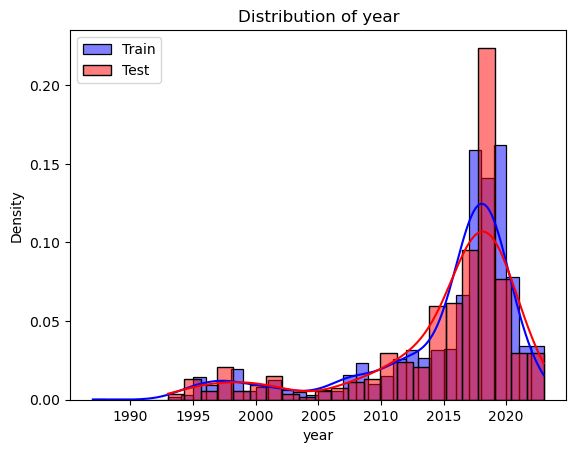

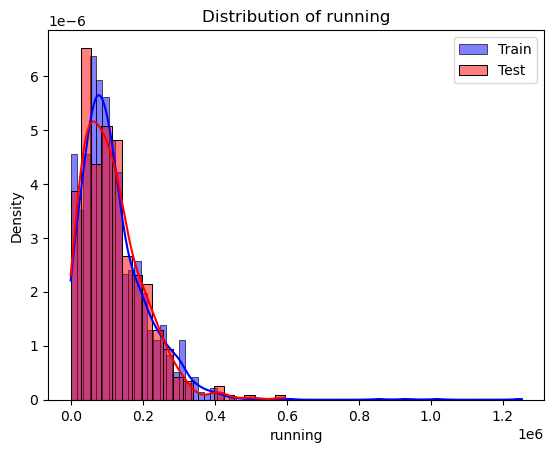

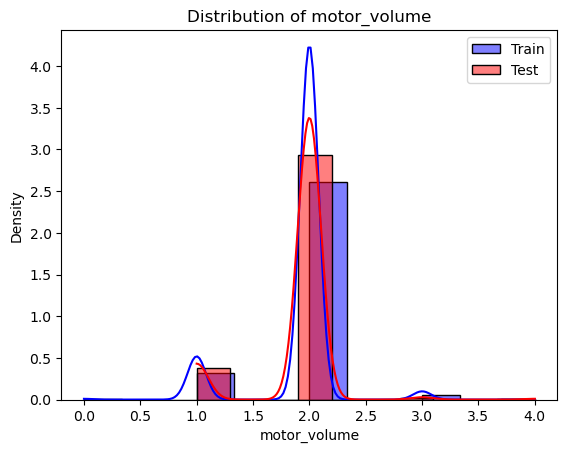

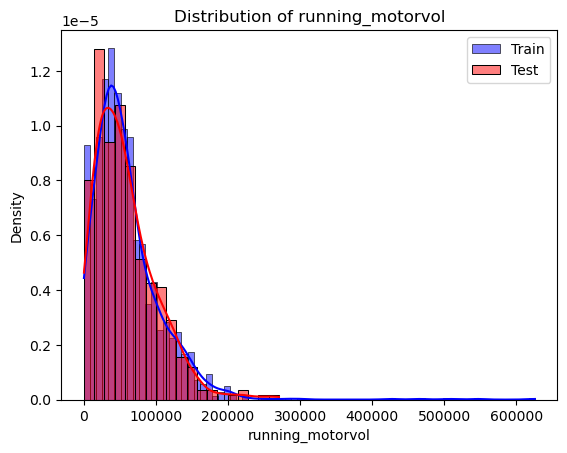

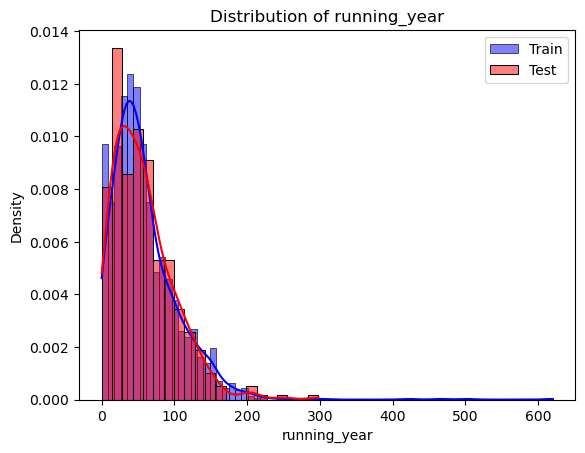

In [21]:
for column in num_col:
    try:
        sns.histplot(train[column], color="blue", label="Train", kde=True, stat="density")
        sns.histplot(test[column], color="red", label="Test", kde=True, stat="density")
        plt.title(f'Distribution of {column}')
        plt.legend()
        plt.show()
    except KeyError:
        print(f"Column {column} not found in one of the datasets, skipping this column.")


In [23]:
# Kolmogorov Smirnov test
# 쨌든 두 분포 비슷
from scipy.stats import ks_2samp

for column in num_col:
    try:
        statistic, p_value = ks_2samp(train[column], test[column])
        print(f'{column} - KS test statistic: {statistic.round(4)}, p-value: {p_value.round(4)}')
    except KeyError:
        print(f"Column {column} not found in one of the datasets, skipping this column.")

year - KS test statistic: 0.0318, p-value: 0.8823
running - KS test statistic: 0.0508, p-value: 0.3523
motor_volume - KS test statistic: 0.0112, p-value: 1.0
running_motorvol - KS test statistic: 0.0458, p-value: 0.4798
running_year - KS test statistic: 0.0466, p-value: 0.4589


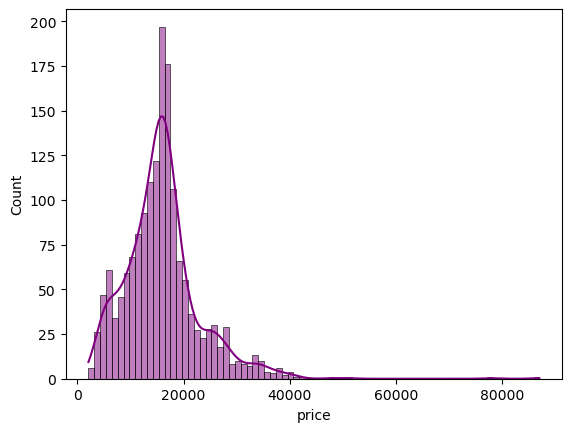

In [25]:
sns.histplot(train[target], kde=True, color='PURPLE');

In [26]:
train.head()

,model,year,motor_type,running,color,type,status,motor_volume,price,running_motorvol,running_year
0,toyota,2022,petrol,3000,skyblue,sedan,excellent,2,24500,1500,1
1,mercedes-benz,2014,petrol,132000,black,sedan,excellent,2,25500,66000,65
2,kia,2018,petrol,152887,other,sedan,excellent,2,11700,76443,75
3,mercedes-benz,2002,petrol,220479,golden,sedan,excellent,3,12000,68899,110
4,mercedes-benz,2017,petrol,130000,black,sedan,good,2,26000,65000,64


### 3. EDA

C:\Users\LEE AYOON\AppData\Local\Temp\ipykernel_30832\4009399514.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=categorical_df, x=column, palette='viridis')


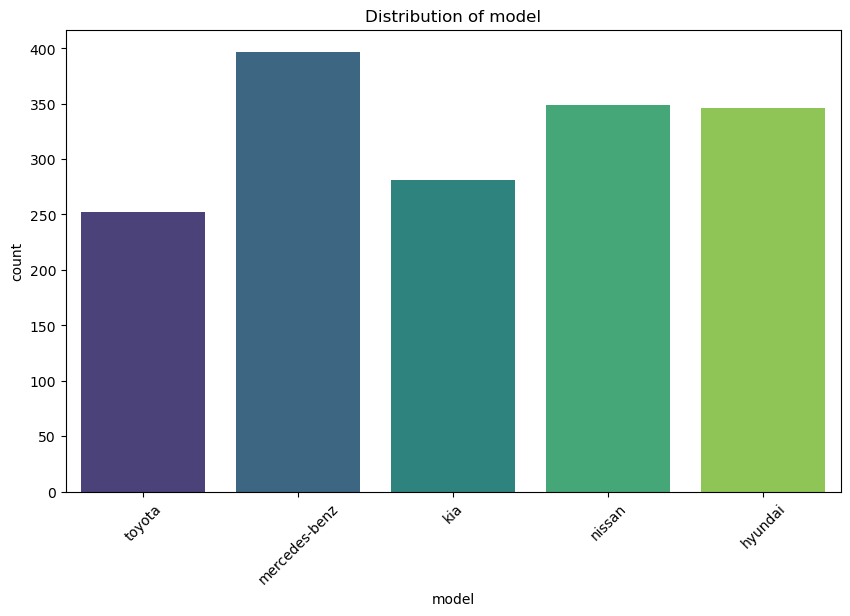

C:\Users\LEE AYOON\AppData\Local\Temp\ipykernel_30832\4009399514.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=categorical_df, x=column, palette='viridis')


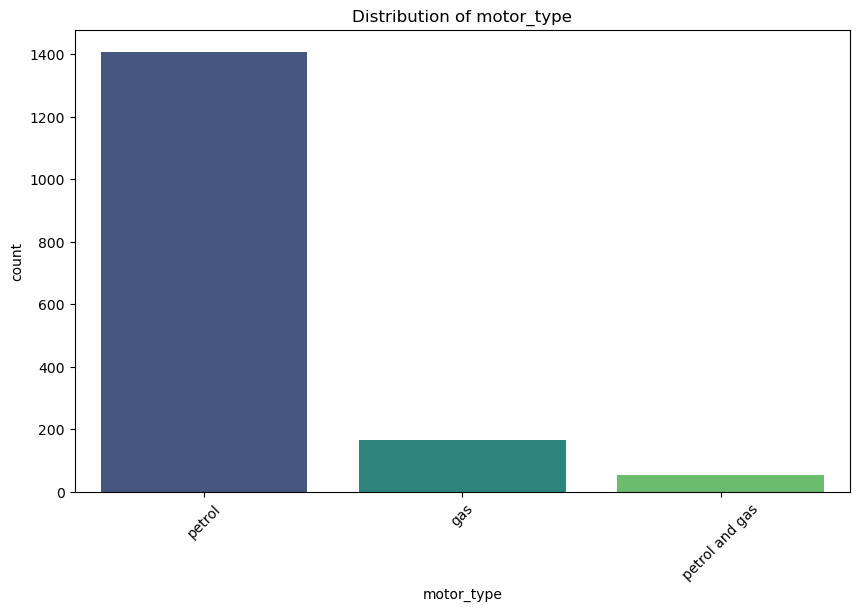

C:\Users\LEE AYOON\AppData\Local\Temp\ipykernel_30832\4009399514.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=categorical_df, x=column, palette='viridis')


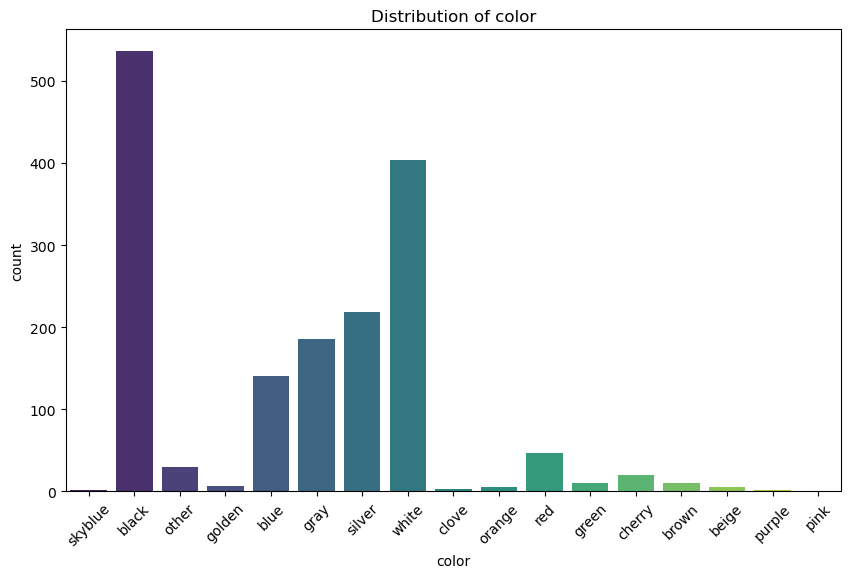

C:\Users\LEE AYOON\AppData\Local\Temp\ipykernel_30832\4009399514.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=categorical_df, x=column, palette='viridis')


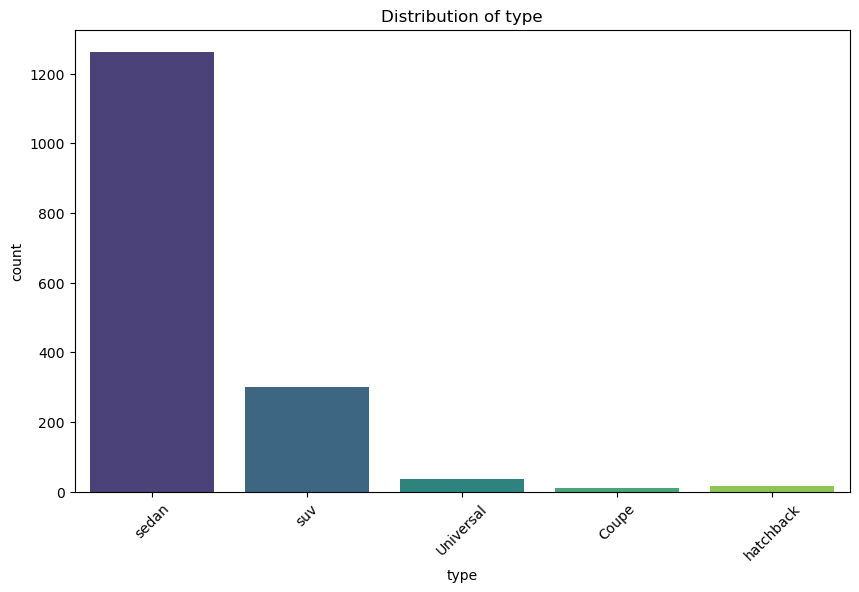

C:\Users\LEE AYOON\AppData\Local\Temp\ipykernel_30832\4009399514.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=categorical_df, x=column, palette='viridis')


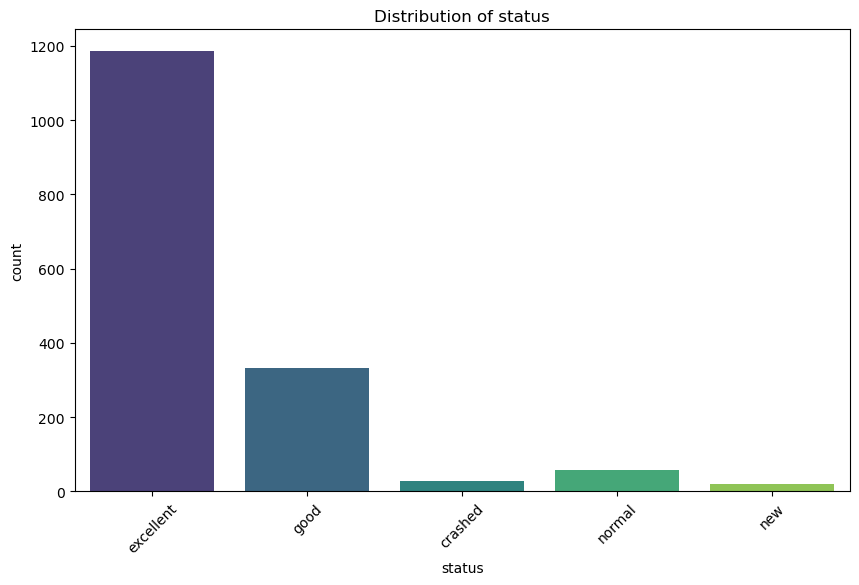

In [27]:
# 범주형 데이터만 선택
categorical_df = train.select_dtypes(include=['object'])

# 각 범주형 열에 대해 분포를 시각화
for column in categorical_df.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=categorical_df, x=column, palette='viridis')
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
    plt.show()

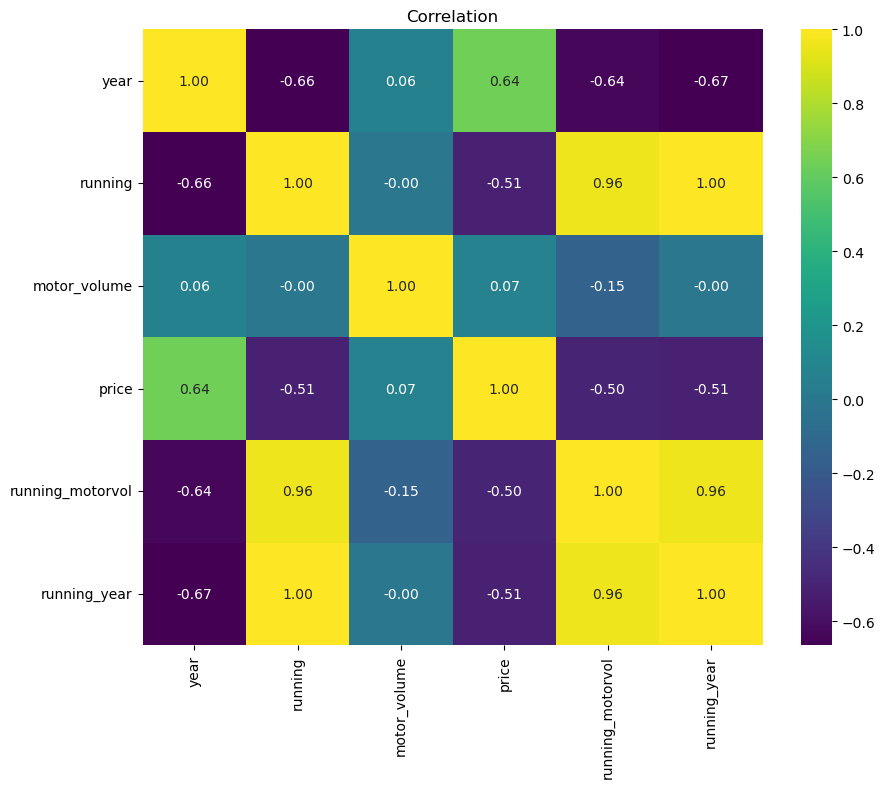

In [25]:
# 수치형 데이터
numeric_df = train.select_dtypes(include=['float64', 'int64'])

# 상관관계 히트맵
correlation = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation')
plt.show()

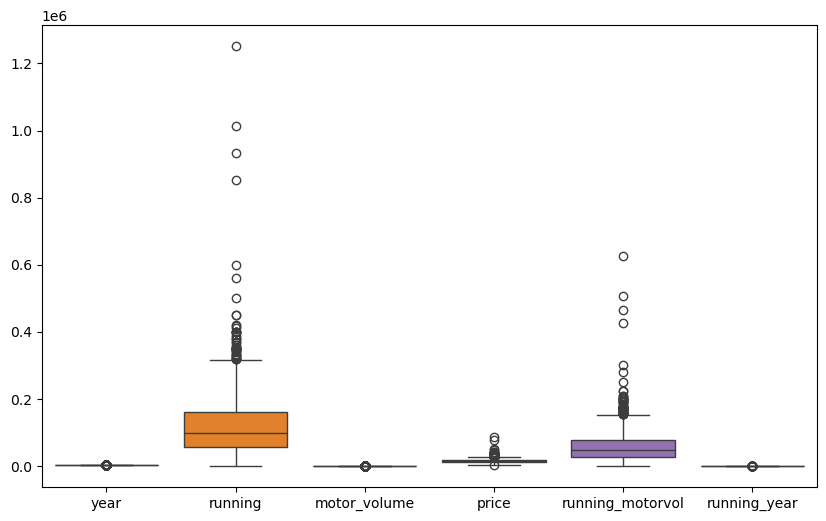

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train.select_dtypes(include=['float64', 'int64']))
plt.show()

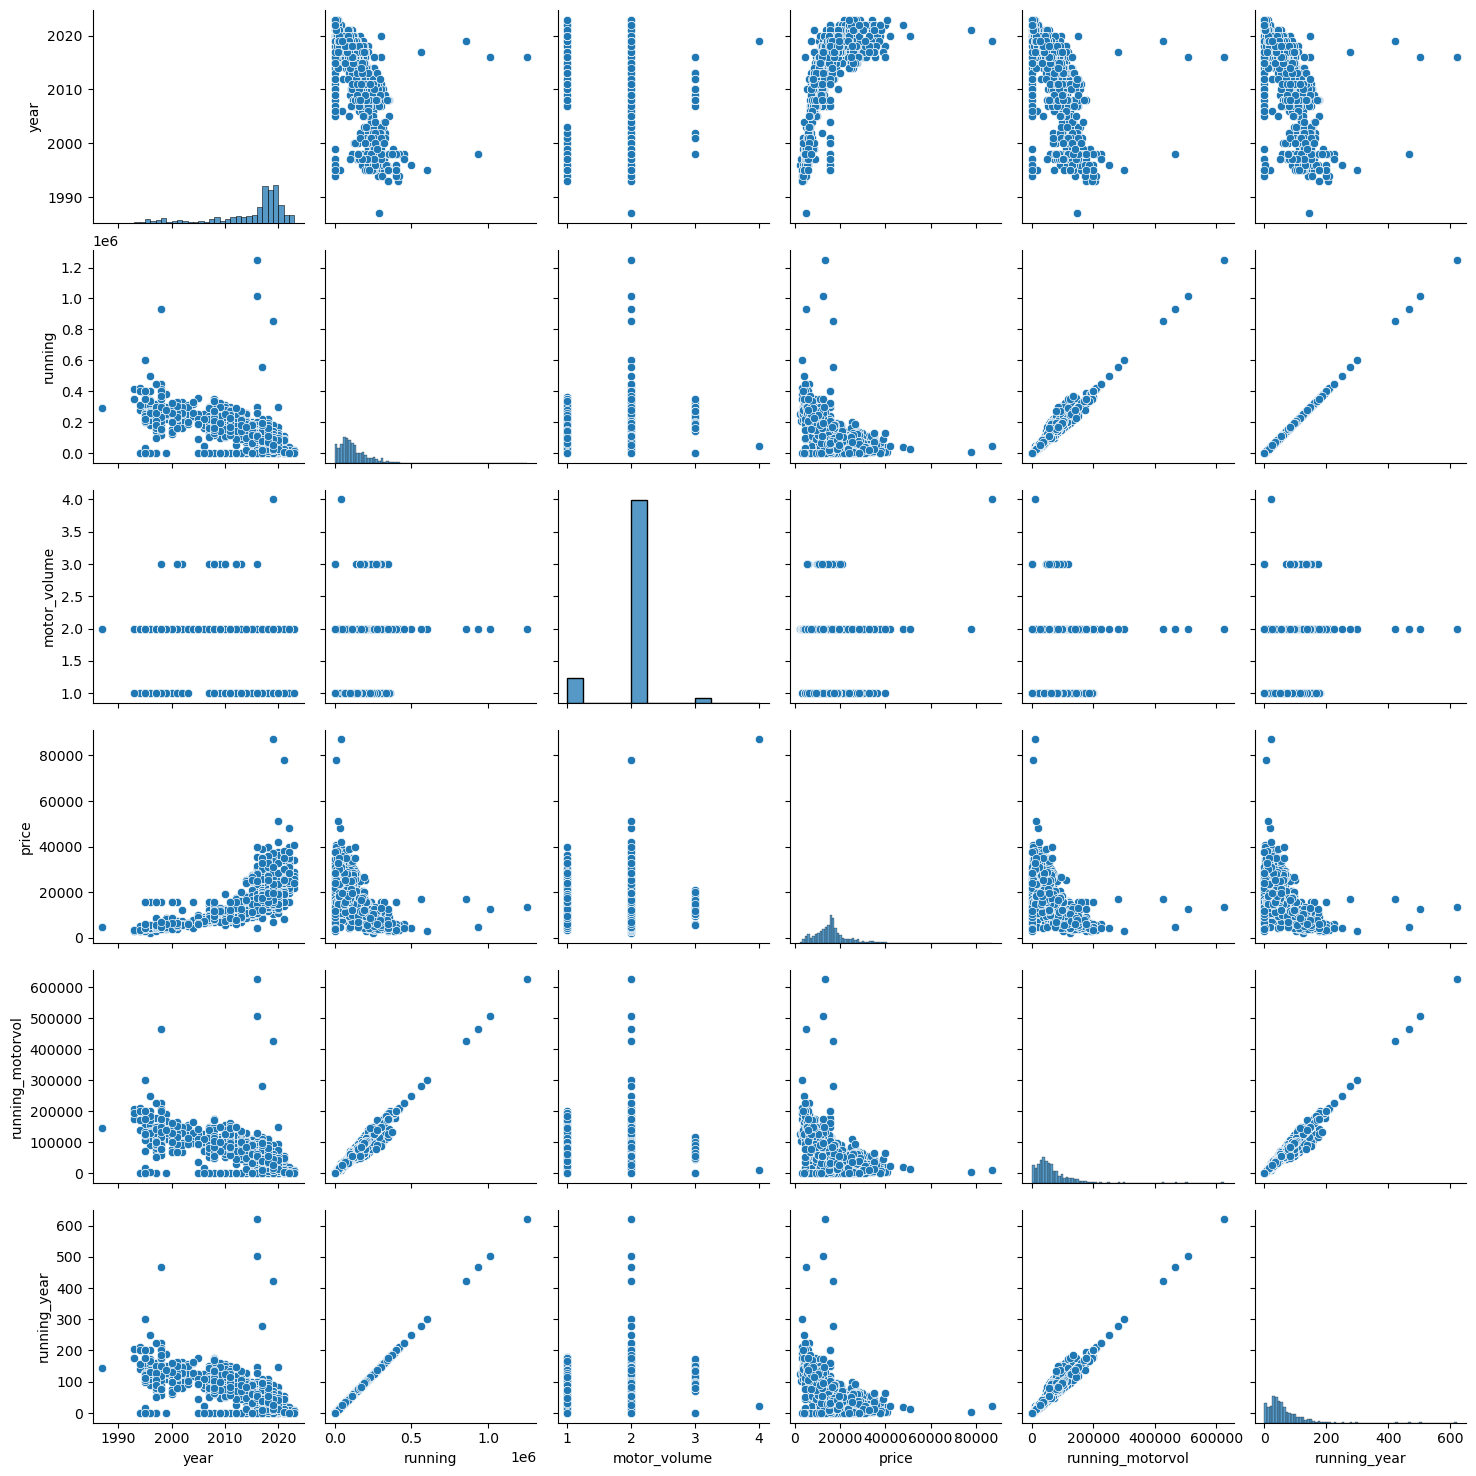

In [28]:
sns.pairplot(train.select_dtypes(include=['float64', 'int64']))
plt.show()